# Data Visualization: Week 2, Lecture 1

#### About the dataset
- Data obtained using Google Trends https://trends.google.com/trends/explore?date=all&geo=US&q=sunscreen&hl=en
- Access CSV here:  https://drive.google.com/file/d/1DS9_ENBsMZB7Mjd-WljuT7H2YSZ2PtF0/view?usp=sharing
- Dataset as of November 2023 also in repo as `sunscreen_popularity.txt` in `data` subfolder.

#### Learning Objectives
By the end of this CodeAlong, students will be able to:
- Perform and interpret the results of the augmented Dickey-Fuller test
- Identify the necessary order of differencing to achieve stationarity
- Plot ACF and PACF plots
- Fit and evaluate an ARIMA model

In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa

In [2]:
# set_config(transform_output="pandas")
# plt.rcParams["figure.figsize"] = (12, 4)
# sns.set_context("talk", font_scale=0.9)

## Custom functions

These functions are imported from the LP.

In [3]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r_squared = r2_score(y_true, y_pred)
    if verbose == True:
        # Print Result with Label and Header
        header = "-"*60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
    if output_dict == True:
        metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
        return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
    # Get predictions for training data
    y_train_pred = reg.predict(X_train)

    # Call the helper function to obtain regression metrics for training data
    results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = reg.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

    # Store results in a dataframe if ouput_frame is True
    if output_frame:
        results_df = pd.DataFrame([results_train,results_test])
        # Set the label as the index 
        results_df = results_df.set_index('Label')
        # Set index.name to none to get a cleaner looking result
        results_df.index.name=None
        # Return the dataframe
        return results_df.round(3)
    
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

## Importing data & exploratory analysis

In [4]:
# sunscreen
df = pd.read_csv('data/sunscreen_popularity.txt', skiprows= [0])
df.head()

,Month,sunscreen: (United States)
0,2004-01,6
1,2004-02,7
2,2004-03,9
3,2004-04,13
4,2004-05,17


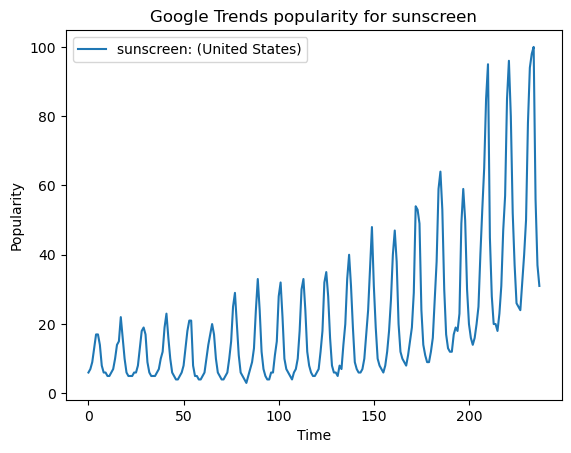

In [5]:
# Visualize the data
ax = df.plot()
ax.set(ylabel="Popularity", xlabel="Time", title="Google Trends popularity for sunscreen");

In [6]:
df.head(3)

,Month,sunscreen: (United States)
0,2004-01,6
1,2004-02,7
2,2004-03,9


#### Set month to index, set frequency, and check for nulls

In [19]:
# cast month as date time, set index, set freq, check nulls
df['Month']=pd.to_datetime(df['Month'], format='%Y-%m')

df=df.set_index('Month')


In [21]:
#df.resample("MS").asfreq()

df= df.asfreq("MS")

In [22]:
df.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01'],
              dtype='datetime64[ns]', name='Month', length=238, freq='MS')

In [24]:
df.isnull().sum()

sunscreen: (United States)    0
dtype: int64

#### Train-test split with test_size=0.05, check dimensions, and plot train & test

In [29]:
# train-test split
train, test = train_test_split(df, test_size=0.05)
train.shape, test.shape

((226, 1), (12, 1))

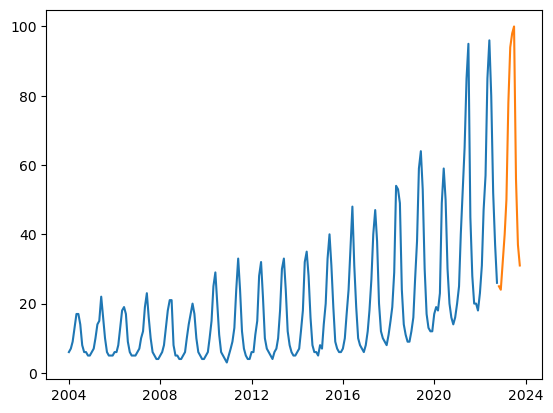

In [30]:
# plot train and test

plt.plot(train)
plt.plot(test)

## Testing for stationarity

Recall that we use the augmented Dickey-Fuller test to evaluate whether our data are stationary.

If the p-value is less than alpha, we reject the null hypothesis of non-stationarity. Otherwise we fail to reject.

### Use the ADF to evaluate for stationarity

In [31]:
# use get_adfuller_results
get_adfuller_results(train)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.360858,15,210,0.998991,0.05,False


Fail to reject

### Use the ADF to evaluate whether once-differenced data are stationary

In [34]:
# use get_adfuller_results
dfd=df.diff().dropna()
get_adfuller_results(dfd)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-4.17037,14,222,0.000739,0.05,True


### Plot the differenced data, ACF, and PACF

#### ⚠️ Important! ⚠️

If we will be modeling on differenced data, we should check **the ACF and PACF of the differenced data**, _not_ the original data.

In [12]:
# use ndiffs


### Plot the differenced data as well as ACF and PACF

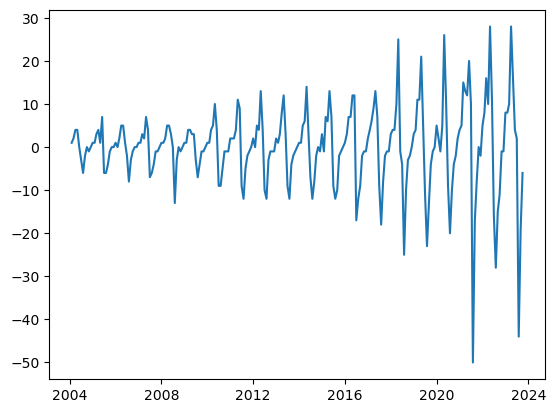

In [35]:
# plot differenced data
plt.plot(dfd)

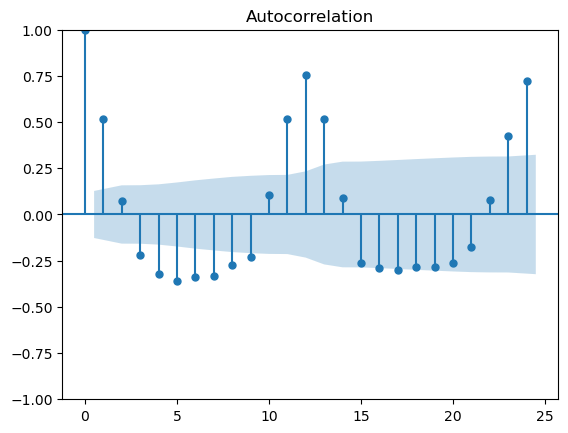

In [41]:
# plot ACF
tsa.graphics.plot_acf(dfd);

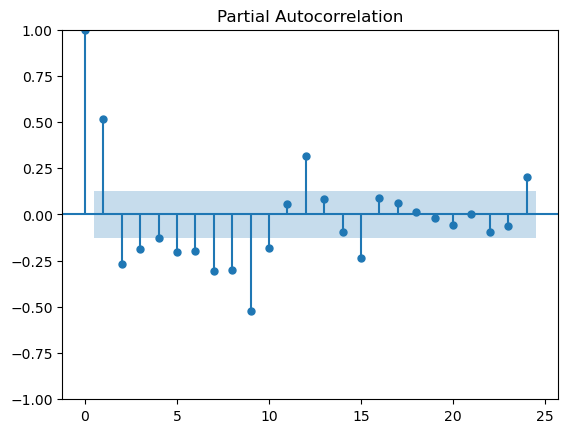

In [40]:
# plot PACF
tsa.graphics.plot_pacf(dfd, method='ywm');

## Fitting an ARIMA model

Remember that identifying the orders of an ARIMA model can be challenging when both p and q are non-zero.

There are also seasonal trends in this dataset. Our linear ARIMA model may not capture those patterns well!

Let's start with a model of order (2,1,2).

In [42]:
# First define the orders (p,d,q)
p =2
d =1
q = 2

# Now instantiate the model with the data and fit
model = tsa.ARIMA(train, order=(p,d,q)).fit()

### NOTE train is not the differenced data

C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [43]:
model

## use model.summary()

## Evaluating the ARIMA model

Check the model summary.

Store the model forecast using `model.get_forecast()` as `preds_df`

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     sunscreen: (United States)   No. Observations:                  226
Model:                         ARIMA(2, 1, 2)   Log Likelihood                -713.160
Date:                        Mon, 27 Nov 2023   AIC                           1436.321
Time:                                20:26:54   BIC                           1453.401
Sample:                            01-01-2004   HQIC                          1443.215
                                 - 10-01-2022                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6884      0.017     99.503      0.000       1.655       1.722
ar.L2         -0.9549      0.018    -53.270      0.000      -0.990      -0.920
ma.L1         -1.7743      0.030    -59.138      0.000      -1.833      -1.716
ma.L2          0.8549      0.033     25.814      0.000       0.790       0.920
sigma2        32.4815      1.787     18.177      0.000      28.979      35.984
===================================================================================
Ljung-Box (L1) (Q):                   6.74   Jarque-Bera (JB):               299.03
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              13.86   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# use model.get_forecast()
# what does summary_frame() do? why might this be useful?
pred_df=model.get_forecast(steps=len(test)).summary_frame()

## Check forecast by plotting and calculating evaluation metrics

### Additional custom functions

In [50]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

### Use the custom functions to plot the forecast, display the evaluation metrics, and plot model diagnostics

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Month'>)

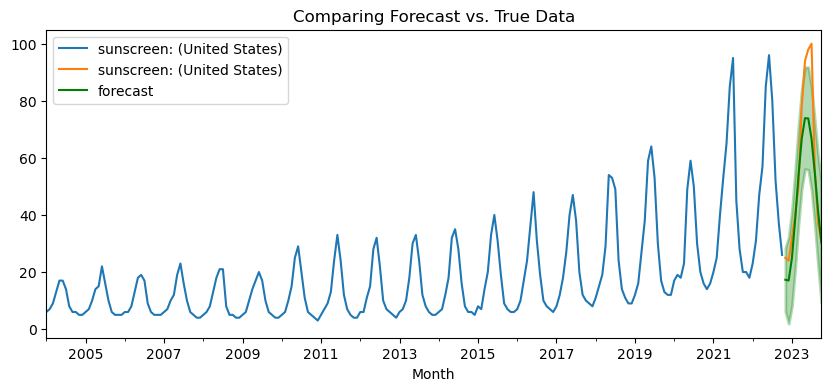

In [58]:
plot_forecast(train, test, pred_df)

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Month'>)

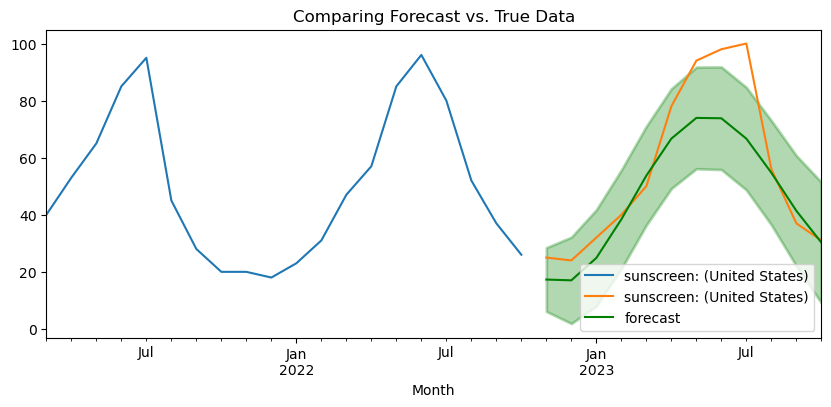

In [57]:
# use plot_forecast()

plot_forecast(train.tail(20), test, pred_df)

In [56]:
# use regression_metrics_ts
regression_metrics_ts(test, pred_df['mean'])


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10.201
- MSE = 201.952
- RMSE = 14.211
- R^2 = 0.744
- MAPE = 16.99%


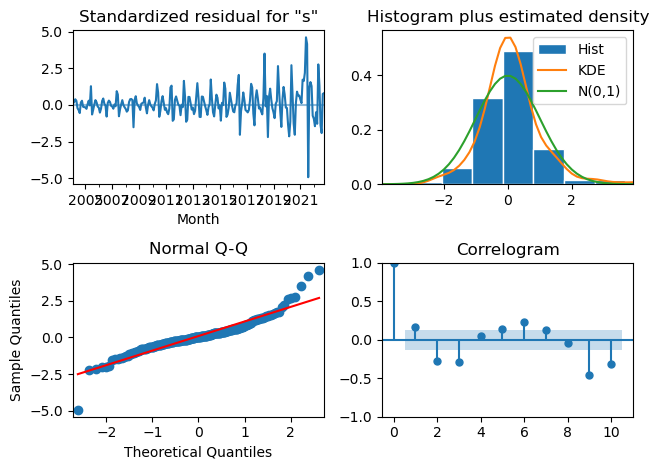

In [52]:
# use model.plot_diagnostics()

model.plot_diagnostics()
# plotted only on the training data predictions
plt.tight_layout()

try different model metrics, compare diagnositc plots, try different models.

Residuals should not be correlated together.
Q+Q should be lined up all the way down
residuals have some peaks at the end


AttributeError: Line2D.set() got an unexpected keyword argument 'line'

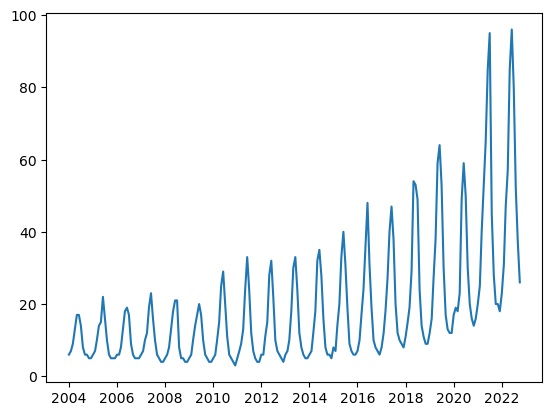

In [62]:
plt.plot(train, label='true')
plt.plot(model.predict(), label='predicted', line= ":")

plt.legend()